## Part 1: Setup and GPU Configuration

In [1]:
# GPU Setup - MUST RUN FIRST
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler  # Use MinMaxScaler for [0,1] range
from sklearn.model_selection import train_test_split
from scipy import stats
from tqdm import tqdm
import json
import pickle
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Seeds
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: NVIDIA A100-SXM4-40GB


## Part 2: Feature Type Definitions (CRITICAL)

In [2]:
# ============================================================================
# FEATURE TYPE DEFINITIONS - Used for post-processing
# ============================================================================

# Integer features (counts - must be >= 0 and integer)
INTEGER_FEATURES = [
    'announcements', 'withdrawals', 'nlri_ann', 'dups',
    'origin_0', 'origin_2', 'origin_changes',
    'imp_wd', 'imp_wd_spath', 'imp_wd_dpath',
    'as_path_max', 'unique_as_path_max',
    'edit_distance_max',
    'edit_distance_dict_0', 'edit_distance_dict_1', 'edit_distance_dict_2',
    'edit_distance_dict_3', 'edit_distance_dict_4', 'edit_distance_dict_5',
    'edit_distance_dict_6',
    'edit_distance_unique_dict_0', 'edit_distance_unique_dict_1',
    'number_rare_ases',
    'nadas', 'flaps'
]

# Continuous features (can be float but must be >= 0)
CONTINUOUS_FEATURES = [
    'edit_distance_avg',
    'rare_ases_avg'
]

# All features
ALL_FEATURES = [
    'announcements', 'withdrawals', 'nlri_ann', 'dups',
    'origin_0', 'origin_2', 'origin_changes',
    'imp_wd', 'imp_wd_spath', 'imp_wd_dpath',
    'as_path_max', 'unique_as_path_max',
    'edit_distance_avg', 'edit_distance_max',
    'edit_distance_dict_0', 'edit_distance_dict_1', 'edit_distance_dict_2',
    'edit_distance_dict_3', 'edit_distance_dict_4', 'edit_distance_dict_5',
    'edit_distance_dict_6',
    'edit_distance_unique_dict_0', 'edit_distance_unique_dict_1',
    'number_rare_ases', 'rare_ases_avg',
    'nadas', 'flaps'
]

print(f"Integer features: {len(INTEGER_FEATURES)}")
print(f"Continuous features: {len(CONTINUOUS_FEATURES)}")
print(f"Total: {len(ALL_FEATURES)}")

Integer features: 25
Continuous features: 2
Total: 27


In [3]:
# ============================================================================
# POST-PROCESSING FUNCTION (CRITICAL)
# ============================================================================

def post_process_synthetic_data(synthetic_data, feature_names, scaler):
    """
    Post-process synthetic data:
    1. Inverse transform (denormalize)
    2. Clip negative values to 0
    3. Round integer features
    
    Args:
        synthetic_data: numpy array (n_samples, seq_len, n_features) - NORMALIZED
        feature_names: list of feature names
        scaler: fitted MinMaxScaler
    
    Returns:
        processed_data: numpy array with proper constraints
    """
    n_samples, seq_len, n_features = synthetic_data.shape
    
    # Step 1: Flatten for inverse transform
    flat_data = synthetic_data.reshape(-1, n_features)
    
    # Step 2: Inverse transform (denormalize)
    denorm_data = scaler.inverse_transform(flat_data)
    
    # Step 3: Apply constraints per feature
    for i, feat in enumerate(feature_names):
        # Clip all features to >= 0 (all BGP features are non-negative)
        denorm_data[:, i] = np.maximum(denorm_data[:, i], 0)
        
        # Round integer features
        if feat in INTEGER_FEATURES:
            denorm_data[:, i] = np.round(denorm_data[:, i]).astype(int)
    
    # Step 4: Reshape back
    processed_data = denorm_data.reshape(n_samples, seq_len, n_features)
    
    return processed_data


def validate_synthetic_data(synthetic_data, feature_names):
    """
    Validate that synthetic data meets constraints.
    """
    flat = synthetic_data.reshape(-1, len(feature_names))
    
    print("\nValidation Report:")
    print("-" * 50)
    
    issues = []
    
    for i, feat in enumerate(feature_names):
        col = flat[:, i]
        min_val = col.min()
        max_val = col.max()
        has_negative = min_val < 0
        has_float = not np.allclose(col, np.round(col)) if feat in INTEGER_FEATURES else False
        
        status = "✓" if not has_negative and not has_float else "✗"
        
        if has_negative or has_float:
            issues.append(feat)
            print(f"{status} {feat}: min={min_val:.2f}, max={max_val:.2f}, "
                  f"neg={has_negative}, float={has_float}")
    
    if not issues:
        print("✓ All features passed validation!")
    else:
        print(f"\n✗ {len(issues)} features have issues: {issues}")
    
    return len(issues) == 0

print("Post-processing functions defined.")

Post-processing functions defined.


## Part 3: Configuration

In [4]:
# ============================================================================
# CONFIGURATION
# ============================================================================

# Paths
DATA_PATH = '/home/smotaali/GAN_Traffic_Producer/RIPE/rrc04_updates_20251116_extracted_discovered.csv'
OUTPUT_DIR = '/home/smotaali/GAN_Traffic_Producer/results/gan_outputs/'

# Sequence parameters
SEQ_LEN = 30
STRIDE = 1

# ============================================================================
# FIXED HYPERPARAMETERS (based on best practices)
# ============================================================================
BATCH_SIZE = 64  # Smaller batch for stability
EPOCHS = 150

# SEPARATE LEARNING RATES (key fix!)
LR_G = 0.0002  # Generator learning rate
LR_D = 0.0001  # Discriminator learning rate (LOWER to prevent D from dominating)

BETA1 = 0.5
BETA2 = 0.999

# Model architecture
HIDDEN_DIM = 128
LATENT_DIM = 32
NUM_LAYERS = 2  # Reduced for stability

# Training stability
LABEL_SMOOTHING = 0.1  # Smooth labels: real=0.9, fake=0.1
NOISE_STD = 0.05  # Add noise to discriminator inputs
N_CRITIC = 1  # Train D only once per G update
CLIP_VALUE = 1.0  # Gradient clipping

# Data split
TEST_SIZE = 0.2
VAL_SIZE = 0.1

# Generation
N_SYNTHETIC = 2000

os.makedirs(OUTPUT_DIR, exist_ok=True)
print("Configuration set.")
print(f"LR_G: {LR_G}, LR_D: {LR_D}")
print(f"Label smoothing: {LABEL_SMOOTHING}")

Configuration set.
LR_G: 0.0002, LR_D: 0.0001
Label smoothing: 0.1


## Part 4: Data Loading and Preprocessing

In [5]:
# Load data
print("Loading data...")
df = pd.read_csv(DATA_PATH)
print(f"Total rows: {len(df):,}")
print(f"Labels: {df['label'].value_counts().to_dict()}")

# Filter normal traffic
df_normal = df[df['discovered_label'] == 'likely_normal'].copy()
print(f"Normal rows: {len(df_normal):,}")

# Select features
available_features = [f for f in ALL_FEATURES if f in df_normal.columns]
print(f"Available features: {len(available_features)}")

# Get feature indices for post-processing
integer_indices = [available_features.index(f) for f in INTEGER_FEATURES if f in available_features]
continuous_indices = [available_features.index(f) for f in CONTINUOUS_FEATURES if f in available_features]

# Extract data
data = df_normal[available_features].fillna(0).values
NUM_FEATURES = len(available_features)
print(f"Data shape: {data.shape}")

Loading data...
Total rows: 86,387
Labels: {'normal': 86387}
Normal rows: 67,940
Available features: 27
Data shape: (67940, 27)


In [6]:
# Show original data statistics (BEFORE normalization)
print("\nOriginal Data Statistics (BEFORE normalization):")
print("-" * 60)
for i, feat in enumerate(available_features[:10]):  # Show first 10
    print(f"{feat}: min={data[:, i].min():.2f}, max={data[:, i].max():.2f}, "
          f"mean={data[:, i].mean():.2f}")


Original Data Statistics (BEFORE normalization):
------------------------------------------------------------
announcements: min=1.00, max=1379.00, mean=108.67
withdrawals: min=0.00, max=239.00, mean=5.77
nlri_ann: min=1.00, max=1379.00, mean=108.67
dups: min=0.00, max=51.00, mean=2.18
origin_0: min=0.00, max=1333.00, mean=89.16
origin_2: min=0.00, max=548.00, mean=19.39
origin_changes: min=0.00, max=70.00, mean=3.18
imp_wd: min=0.00, max=81.00, mean=4.64
imp_wd_spath: min=0.00, max=46.00, mean=1.19
imp_wd_dpath: min=0.00, max=81.00, mean=3.45


In [7]:
# Normalize using MinMaxScaler (scales to [0, 1])
# This allows us to use Sigmoid output in generator
print("\nNormalizing with MinMaxScaler [0, 1]...")
scaler = MinMaxScaler(feature_range=(0, 1))
data_norm = scaler.fit_transform(data)

print(f"Normalized range: [{data_norm.min():.4f}, {data_norm.max():.4f}]")
print(f"Mean: {data_norm.mean():.4f}")


Normalizing with MinMaxScaler [0, 1]...
Normalized range: [0.0000, 1.0000]
Mean: 0.0693


In [8]:
# Create sequences
print(f"\nCreating sequences (T={SEQ_LEN}, stride={STRIDE})...")
sequences = []
for i in range(0, len(data_norm) - SEQ_LEN + 1, STRIDE):
    sequences.append(data_norm[i:i + SEQ_LEN])
sequences = np.array(sequences)
print(f"Sequences: {sequences.shape}")

# Split
X_train_val, X_test = train_test_split(sequences, test_size=TEST_SIZE, random_state=SEED)
X_train, X_val = train_test_split(X_train_val, test_size=VAL_SIZE, random_state=SEED)

print(f"Train: {X_train.shape[0]:,}")
print(f"Val: {X_val.shape[0]:,}")
print(f"Test: {X_test.shape[0]:,}")

# DataLoaders
train_tensor = torch.FloatTensor(X_train).to(device)
train_loader = DataLoader(TensorDataset(train_tensor), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
print(f"Batches: {len(train_loader)}")


Creating sequences (T=30, stride=1)...
Sequences: (67911, 30, 27)
Train: 48,895
Val: 5,433
Test: 13,583
Batches: 763


In [9]:
# ============================================================================
# FIXED LSTM-GAN with Sigmoid output and stability improvements
# ============================================================================

class LSTM_Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(latent_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()  # OUTPUT IN [0, 1] - matches MinMaxScaler
        )
    
    def forward(self, z):
        batch_size, seq_len, _ = z.shape
        out, _ = self.lstm(z)
        # Reshape for batch norm
        out = out.contiguous().view(-1, out.size(-1))
        out = self.fc(out)
        return out.view(batch_size, seq_len, -1)


class LSTM_Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),  # More dropout
            nn.Linear(hidden_dim // 2, 1)
            # No sigmoid - using BCEWithLogitsLoss
        )
    
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


class FixedLSTMGAN:
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers, seq_len, device):
        self.device = device
        self.latent_dim = latent_dim
        self.seq_len = seq_len
        
        self.G = LSTM_Generator(latent_dim, hidden_dim, input_dim, num_layers).to(device)
        self.D = LSTM_Discriminator(input_dim, hidden_dim, num_layers).to(device)
        self.criterion = nn.BCEWithLogitsLoss()
        
    def train(self, train_loader, epochs, lr_g=0.0002, lr_d=0.0001, 
              label_smoothing=0.1, noise_std=0.05):
        """
        Train with stability improvements:
        - Separate learning rates
        - Label smoothing
        - Noise injection to D
        - Gradient clipping
        """
        opt_g = optim.Adam(self.G.parameters(), lr=lr_g, betas=(BETA1, BETA2))
        opt_d = optim.Adam(self.D.parameters(), lr=lr_d, betas=(BETA1, BETA2))
        
        # Learning rate schedulers
        scheduler_g = optim.lr_scheduler.StepLR(opt_g, step_size=50, gamma=0.9)
        scheduler_d = optim.lr_scheduler.StepLR(opt_d, step_size=50, gamma=0.9)
        
        history = {'g_loss': [], 'd_loss': [], 'd_real': [], 'd_fake': []}
        start = time.time()
        
        # Smoothed labels
        real_label = 1.0 - label_smoothing  # 0.9
        fake_label = label_smoothing  # 0.1
        
        for epoch in range(epochs):
            g_losses, d_losses = [], []
            d_reals, d_fakes = [], []
            
            for batch in train_loader:
                real = batch[0]
                bs = real.size(0)
                
                # Smoothed labels
                real_labels = torch.full((bs, 1), real_label).to(self.device)
                fake_labels = torch.full((bs, 1), fake_label).to(self.device)
                
                # =====================
                # Train Discriminator
                # =====================
                opt_d.zero_grad()
                
                # Add noise to real data (instance noise)
                real_noisy = real + noise_std * torch.randn_like(real)
                real_noisy = torch.clamp(real_noisy, 0, 1)  # Keep in [0,1]
                
                d_real_out = self.D(real_noisy)
                loss_real = self.criterion(d_real_out, real_labels)
                
                # Generate fake
                z = torch.randn(bs, self.seq_len, self.latent_dim).to(self.device)
                fake = self.G(z)
                
                # Add noise to fake
                fake_noisy = fake.detach() + noise_std * torch.randn_like(fake)
                fake_noisy = torch.clamp(fake_noisy, 0, 1)
                
                d_fake_out = self.D(fake_noisy)
                loss_fake = self.criterion(d_fake_out, fake_labels)
                
                d_loss = loss_real + loss_fake
                d_loss.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(self.D.parameters(), CLIP_VALUE)
                opt_d.step()
                
                # =====================
                # Train Generator (train more when D is strong)
                # =====================
                n_g_steps = 2 if d_loss.item() < 0.5 else 1  # Train G more when D is too good
                
                for _ in range(n_g_steps):
                    opt_g.zero_grad()
                    z = torch.randn(bs, self.seq_len, self.latent_dim).to(self.device)
                    fake = self.G(z)
                    d_fake_out = self.D(fake)
                    
                    # Generator wants D to output real_label
                    g_loss = self.criterion(d_fake_out, real_labels)
                    
                    # Feature matching loss (stabilizes training)
                    real_mean = real.mean(dim=[0, 1])
                    fake_mean = fake.mean(dim=[0, 1])
                    fm_loss = torch.mean((real_mean - fake_mean) ** 2)
                    
                    total_g_loss = g_loss + 0.1 * fm_loss
                    total_g_loss.backward()
                    
                    torch.nn.utils.clip_grad_norm_(self.G.parameters(), CLIP_VALUE)
                    opt_g.step()
                
                g_losses.append(g_loss.item())
                d_losses.append(d_loss.item())
                d_reals.append(torch.sigmoid(d_real_out).mean().item())
                d_fakes.append(torch.sigmoid(d_fake_out).mean().item())
            
            scheduler_g.step()
            scheduler_d.step()
            
            history['g_loss'].append(np.mean(g_losses))
            history['d_loss'].append(np.mean(d_losses))
            history['d_real'].append(np.mean(d_reals))
            history['d_fake'].append(np.mean(d_fakes))
            
            if (epoch + 1) % 20 == 0:
                print(f"  Epoch {epoch+1:3d}/{epochs} | D: {history['d_loss'][-1]:.4f} | "
                      f"G: {history['g_loss'][-1]:.4f} | D(real): {history['d_real'][-1]:.2f} | "
                      f"D(fake): {history['d_fake'][-1]:.2f}")
        
        print(f"  Training time: {(time.time()-start)/60:.1f} min")
        return history
    
    def generate(self, n_samples):
        self.G.eval()
        with torch.no_grad():
            z = torch.randn(n_samples, self.seq_len, self.latent_dim).to(self.device)
            fake = self.G(z)
        return fake.cpu().numpy()

print("Fixed LSTM-GAN defined.")

Fixed LSTM-GAN defined.


In [10]:
# ============================================================================
# FIXED TimeGAN
# ============================================================================

class TimeGAN_Embedder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super().__init__()
        self.rnn = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, hidden_dim)
    
    def forward(self, x):
        h, _ = self.rnn(x)
        return torch.sigmoid(self.fc(h))


class TimeGAN_Recovery(nn.Module):
    def __init__(self, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()  # Output in [0, 1]
        )
    
    def forward(self, h):
        r, _ = self.rnn(h)
        return self.fc(r)


class TimeGAN_Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, num_layers):
        super().__init__()
        self.rnn = nn.GRU(latent_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, hidden_dim)
    
    def forward(self, z):
        e, _ = self.rnn(z)
        return torch.sigmoid(self.fc(e))


class TimeGAN_Supervisor(nn.Module):
    def __init__(self, hidden_dim, num_layers):
        super().__init__()
        self.rnn = nn.GRU(hidden_dim, hidden_dim, max(1, num_layers - 1), batch_first=True)
        self.fc = nn.Linear(hidden_dim, hidden_dim)
    
    def forward(self, h):
        s, _ = self.rnn(h)
        return torch.sigmoid(self.fc(s))


class TimeGAN_Discriminator(nn.Module):
    def __init__(self, hidden_dim, num_layers):
        super().__init__()
        self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, h):
        d, _ = self.rnn(h)
        return self.fc(d)


class FixedTimeGAN:
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers, device):
        self.device = device
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        self.embedder = TimeGAN_Embedder(input_dim, hidden_dim, num_layers).to(device)
        self.recovery = TimeGAN_Recovery(hidden_dim, input_dim, num_layers).to(device)
        self.generator = TimeGAN_Generator(latent_dim, hidden_dim, num_layers).to(device)
        self.supervisor = TimeGAN_Supervisor(hidden_dim, num_layers).to(device)
        self.discriminator = TimeGAN_Discriminator(hidden_dim, num_layers).to(device)
        
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
    
    def train(self, train_loader, epochs, lr_g=0.0002, lr_d=0.0001, label_smoothing=0.1):
        # Optimizers
        opt_e = optim.Adam(list(self.embedder.parameters()) + list(self.recovery.parameters()), lr=lr_g)
        opt_s = optim.Adam(self.supervisor.parameters(), lr=lr_g)
        opt_g = optim.Adam(list(self.generator.parameters()) + list(self.supervisor.parameters()), lr=lr_g)
        opt_d = optim.Adam(self.discriminator.parameters(), lr=lr_d)  # Slower D
        
        history = {'e_loss': [], 's_loss': [], 'g_loss': [], 'd_loss': []}
        start = time.time()
        
        real_label = 1.0 - label_smoothing
        fake_label = label_smoothing
        
        # Phase 1: Embedding
        print("  Phase 1: Embedding...")
        for epoch in range(epochs // 3):
            e_losses = []
            for batch in train_loader:
                x = batch[0]
                opt_e.zero_grad()
                h = self.embedder(x)
                x_tilde = self.recovery(h)
                loss = self.mse(x, x_tilde)
                loss.backward()
                opt_e.step()
                e_losses.append(loss.item())
            history['e_loss'].append(np.mean(e_losses))
            if (epoch + 1) % 15 == 0:
                print(f"    Epoch {epoch+1}/{epochs//3} | E_loss: {history['e_loss'][-1]:.4f}")
        
        # Phase 2: Supervised
        print("  Phase 2: Supervised...")
        for epoch in range(epochs // 3):
            s_losses = []
            for batch in train_loader:
                x = batch[0]
                opt_s.zero_grad()
                h = self.embedder(x)
                h_s = self.supervisor(h)
                loss = self.mse(h[:, 1:, :], h_s[:, :-1, :])
                loss.backward()
                opt_s.step()
                s_losses.append(loss.item())
            history['s_loss'].append(np.mean(s_losses))
            if (epoch + 1) % 15 == 0:
                print(f"    Epoch {epoch+1}/{epochs//3} | S_loss: {history['s_loss'][-1]:.4f}")
        
        # Phase 3: Joint
        print("  Phase 3: Joint...")
        for epoch in range(epochs // 3):
            g_losses, d_losses = [], []
            for batch in train_loader:
                x = batch[0]
                bs, seq_len, _ = x.shape
                z = torch.randn(bs, seq_len, self.latent_dim).to(self.device)
                
                real_labels = torch.full((bs, seq_len, 1), real_label).to(self.device)
                fake_labels = torch.full((bs, seq_len, 1), fake_label).to(self.device)
                
                # Generator (train 2x when D is strong)
                for _ in range(2):
                    opt_g.zero_grad()
                    h = self.embedder(x)
                    h_s = self.supervisor(h)
                    e_hat = self.generator(z)
                    h_hat = self.supervisor(e_hat)
                    x_hat = self.recovery(h_hat)
                    
                    y_fake = self.discriminator(h_hat)
                    g_loss = self.bce(y_fake, real_labels)
                    g_loss += self.mse(h[:, 1:, :], h_s[:, :-1, :]) * 10
                    
                    # Feature matching
                    g_loss += torch.mean((x_hat.mean(dim=0) - x.mean(dim=0)) ** 2) * 100
                    
                    g_loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.generator.parameters(), CLIP_VALUE)
                    opt_g.step()
                
                # Discriminator
                opt_d.zero_grad()
                h = self.embedder(x)
                e_hat = self.generator(z)
                h_hat = self.supervisor(e_hat)
                
                y_real = self.discriminator(h)
                y_fake = self.discriminator(h_hat.detach())
                
                d_loss = self.bce(y_real, real_labels) + self.bce(y_fake, fake_labels)
                
                # Only update D if not too strong
                if d_loss.item() > 0.3:
                    d_loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), CLIP_VALUE)
                    opt_d.step()
                
                g_losses.append(g_loss.item())
                d_losses.append(d_loss.item())
            
            history['g_loss'].append(np.mean(g_losses))
            history['d_loss'].append(np.mean(d_losses))
            
            if (epoch + 1) % 15 == 0:
                print(f"    Epoch {epoch+1}/{epochs//3} | D: {history['d_loss'][-1]:.4f} | "
                      f"G: {history['g_loss'][-1]:.4f}")
        
        print(f"  Training time: {(time.time()-start)/60:.1f} min")
        return history
    
    def generate(self, n_samples, seq_len):
        self.generator.eval()
        self.supervisor.eval()
        self.recovery.eval()
        with torch.no_grad():
            z = torch.randn(n_samples, seq_len, self.latent_dim).to(self.device)
            e_hat = self.generator(z)
            h_hat = self.supervisor(e_hat)
            x_hat = self.recovery(h_hat)
        return x_hat.cpu().numpy()

print("Fixed TimeGAN defined.")

Fixed TimeGAN defined.


In [11]:
# ============================================================================
# FIXED DoppelGANger
# ============================================================================

class DG_Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(latent_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()  # Output in [0, 1]
        )
    
    def forward(self, z):
        out, _ = self.lstm(z)
        return self.fc(out)


class DG_Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


class FixedDoppelGANger:
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers, seq_len, device):
        self.device = device
        self.latent_dim = latent_dim
        self.seq_len = seq_len
        
        self.G = DG_Generator(latent_dim, hidden_dim, input_dim, num_layers).to(device)
        self.D = DG_Discriminator(input_dim, hidden_dim, num_layers).to(device)
        self.criterion = nn.BCEWithLogitsLoss()
    
    def train(self, train_loader, epochs, lr_g=0.0002, lr_d=0.0001, label_smoothing=0.1):
        opt_g = optim.Adam(self.G.parameters(), lr=lr_g, betas=(BETA1, BETA2))
        opt_d = optim.Adam(self.D.parameters(), lr=lr_d, betas=(BETA1, BETA2))
        
        history = {'g_loss': [], 'd_loss': []}
        start = time.time()
        
        real_label = 1.0 - label_smoothing
        fake_label = label_smoothing
        
        for epoch in range(epochs):
            g_losses, d_losses = [], []
            
            for batch in train_loader:
                real = batch[0]
                bs = real.size(0)
                
                real_labels = torch.full((bs, 1), real_label).to(self.device)
                fake_labels = torch.full((bs, 1), fake_label).to(self.device)
                
                # Train D
                opt_d.zero_grad()
                d_real = self.D(real)
                loss_real = self.criterion(d_real, real_labels)
                
                z = torch.randn(bs, self.seq_len, self.latent_dim).to(self.device)
                fake = self.G(z)
                d_fake = self.D(fake.detach())
                loss_fake = self.criterion(d_fake, fake_labels)
                
                d_loss = loss_real + loss_fake
                
                # Only update if not too strong
                if d_loss.item() > 0.3:
                    d_loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.D.parameters(), CLIP_VALUE)
                    opt_d.step()
                
                # Train G (more times when D is strong)
                n_g = 2 if d_loss.item() < 0.5 else N_CRITIC
                for _ in range(n_g):
                    opt_g.zero_grad()
                    z = torch.randn(bs, self.seq_len, self.latent_dim).to(self.device)
                    fake = self.G(z)
                    d_fake = self.D(fake)
                    g_loss = self.criterion(d_fake, real_labels)
                    
                    # Feature matching
                    g_loss += torch.mean((fake.mean(dim=0) - real.mean(dim=0)) ** 2) * 10
                    
                    g_loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.G.parameters(), CLIP_VALUE)
                    opt_g.step()
                
                g_losses.append(g_loss.item())
                d_losses.append(d_loss.item())
            
            history['g_loss'].append(np.mean(g_losses))
            history['d_loss'].append(np.mean(d_losses))
            
            if (epoch + 1) % 20 == 0:
                print(f"  Epoch {epoch+1:3d}/{epochs} | D: {history['d_loss'][-1]:.4f} | "
                      f"G: {history['g_loss'][-1]:.4f}")
        
        print(f"  Training time: {(time.time()-start)/60:.1f} min")
        return history
    
    def generate(self, n_samples):
        self.G.eval()
        with torch.no_grad():
            z = torch.randn(n_samples, self.seq_len, self.latent_dim).to(self.device)
            fake = self.G(z)
        return fake.cpu().numpy()

print("Fixed DoppelGANger defined.")

Fixed DoppelGANger defined.


## Part 6: Train Models

In [12]:
models = {}
histories = {}
synthetic_raw = {}  # Normalized synthetic data
synthetic_processed = {}  # Post-processed synthetic data

print("="*60)
print("TRAINING WITH FIXED HYPERPARAMETERS")
print("="*60)
print(f"LR_G: {LR_G}, LR_D: {LR_D}")
print(f"Label smoothing: {LABEL_SMOOTHING}")
print(f"Noise std: {NOISE_STD}")
total_start = time.time()

TRAINING WITH FIXED HYPERPARAMETERS
LR_G: 0.0002, LR_D: 0.0001
Label smoothing: 0.1
Noise std: 0.05


In [13]:
# Train LSTM-GAN
print("\n" + "="*60)
print("Training Fixed LSTM-GAN")
print("="*60)

lstmgan = FixedLSTMGAN(NUM_FEATURES, HIDDEN_DIM, LATENT_DIM, NUM_LAYERS, SEQ_LEN, device)
histories['LSTM-GAN'] = lstmgan.train(
    train_loader, EPOCHS, 
    lr_g=LR_G, lr_d=LR_D,
    label_smoothing=LABEL_SMOOTHING,
    noise_std=NOISE_STD
)
models['LSTM-GAN'] = lstmgan

# Generate (normalized)
synthetic_raw['LSTM-GAN'] = lstmgan.generate(N_SYNTHETIC)
print(f"Generated (normalized): {synthetic_raw['LSTM-GAN'].shape}")
print(f"Range: [{synthetic_raw['LSTM-GAN'].min():.4f}, {synthetic_raw['LSTM-GAN'].max():.4f}]")


Training Fixed LSTM-GAN
  Epoch  20/150 | D: 1.3864 | G: 0.6930 | D(real): 0.50 | D(fake): 0.50
  Epoch  40/150 | D: 1.3863 | G: 0.6932 | D(real): 0.50 | D(fake): 0.50
  Epoch  60/150 | D: 1.2818 | G: 0.8509 | D(real): 0.56 | D(fake): 0.43
  Epoch  80/150 | D: 1.3517 | G: 0.7382 | D(real): 0.52 | D(fake): 0.48
  Epoch 100/150 | D: 0.6550 | G: 1.8869 | D(real): 0.90 | D(fake): 0.13
  Epoch 120/150 | D: 0.6709 | G: 2.0654 | D(real): 0.89 | D(fake): 0.11
  Epoch 140/150 | D: 0.6548 | G: 2.0816 | D(real): 0.90 | D(fake): 0.10
  Training time: 24.4 min
Generated (normalized): (2000, 30, 27)
Range: [0.0000, 1.0000]


In [14]:
# Train TimeGAN
print("\n" + "="*60)
print("Training Fixed TimeGAN")
print("="*60)

timegan = FixedTimeGAN(NUM_FEATURES, HIDDEN_DIM, LATENT_DIM, NUM_LAYERS, device)
histories['TimeGAN'] = timegan.train(
    train_loader, EPOCHS,
    lr_g=LR_G, lr_d=LR_D,
    label_smoothing=LABEL_SMOOTHING
)
models['TimeGAN'] = timegan

synthetic_raw['TimeGAN'] = timegan.generate(N_SYNTHETIC, SEQ_LEN)
print(f"Generated (normalized): {synthetic_raw['TimeGAN'].shape}")


Training Fixed TimeGAN
  Phase 1: Embedding...
    Epoch 15/50 | E_loss: 0.0007
    Epoch 30/50 | E_loss: 0.0002
    Epoch 45/50 | E_loss: 0.0001
  Phase 2: Supervised...
    Epoch 15/50 | S_loss: 0.0152
    Epoch 30/50 | S_loss: 0.0150
    Epoch 45/50 | S_loss: 0.0146
  Phase 3: Joint...
    Epoch 15/50 | D: 1.3865 | G: 0.8604
    Epoch 30/50 | D: 1.3862 | G: 0.8563
    Epoch 45/50 | D: 1.3860 | G: 0.8531
  Training time: 21.8 min
Generated (normalized): (2000, 30, 27)


In [15]:
# Train DoppelGANger
print("\n" + "="*60)
print("Training Fixed DoppelGANger")
print("="*60)

doppelganger = FixedDoppelGANger(NUM_FEATURES, HIDDEN_DIM, LATENT_DIM, NUM_LAYERS, SEQ_LEN, device)
histories['DoppelGANger'] = doppelganger.train(
    train_loader, EPOCHS,
    lr_g=LR_G, lr_d=LR_D,
    label_smoothing=LABEL_SMOOTHING
)
models['DoppelGANger'] = doppelganger

synthetic_raw['DoppelGANger'] = doppelganger.generate(N_SYNTHETIC)
print(f"Generated (normalized): {synthetic_raw['DoppelGANger'].shape}")

print(f"\nTotal time: {(time.time()-total_start)/60:.1f} min")


Training Fixed DoppelGANger
  Epoch  20/150 | D: 1.3771 | G: 0.7085
  Epoch  40/150 | D: 1.3862 | G: 0.6959
  Epoch  60/150 | D: 1.3844 | G: 0.7001
  Epoch  80/150 | D: 1.3277 | G: 0.7943
  Epoch 100/150 | D: 1.3183 | G: 0.8180
  Epoch 120/150 | D: 1.3112 | G: 0.8209
  Epoch 140/150 | D: 1.3137 | G: 0.8190
  Training time: 28.9 min
Generated (normalized): (2000, 30, 27)

Total time: 75.2 min


## Part 7: Post-Processing (CRITICAL)

In [16]:
# Post-process all synthetic data
print("="*60)
print("POST-PROCESSING SYNTHETIC DATA")
print("="*60)
print("Steps: Denormalize → Clip negatives → Round integers")

for name, raw_data in synthetic_raw.items():
    print(f"\n--- {name} ---")
    print(f"Before: range=[{raw_data.min():.4f}, {raw_data.max():.4f}]")
    
    # Apply post-processing
    processed = post_process_synthetic_data(raw_data, available_features, scaler)
    synthetic_processed[name] = processed
    
    print(f"After: range=[{processed.min():.2f}, {processed.max():.2f}]")
    
    # Validate
    validate_synthetic_data(processed, available_features)

POST-PROCESSING SYNTHETIC DATA
Steps: Denormalize → Clip negatives → Round integers

--- LSTM-GAN ---
Before: range=[0.0000, 1.0000]
After: range=[0.00, 1379.00]

Validation Report:
--------------------------------------------------
✓ All features passed validation!

--- TimeGAN ---
Before: range=[0.0000, 0.8864]
After: range=[0.00, 1043.00]

Validation Report:
--------------------------------------------------
✓ All features passed validation!

--- DoppelGANger ---
Before: range=[0.0000, 0.9442]
After: range=[0.00, 1063.00]

Validation Report:
--------------------------------------------------
✓ All features passed validation!


In [17]:
# Show sample of processed data
print("\nSample of processed data (first 5 features, first timestep):")
for name, data in synthetic_processed.items():
    print(f"\n{name}:")
    sample = data[0, 0, :5]  # First sequence, first timestep, first 5 features
    for i, val in enumerate(sample):
        print(f"  {available_features[i]}: {val}")


Sample of processed data (first 5 features, first timestep):

LSTM-GAN:
  announcements: 1378.0
  withdrawals: 4.0
  nlri_ann: 1372.0
  dups: 51.0
  origin_0: 1333.0

TimeGAN:
  announcements: 91.0
  withdrawals: 12.0
  nlri_ann: 91.0
  dups: 1.0
  origin_0: 76.0

DoppelGANger:
  announcements: 12.0
  withdrawals: 3.0
  nlri_ann: 7.0
  dups: 0.0
  origin_0: 6.0


## Part 8: Fixed Evaluation Metrics

In [18]:
def calculate_metrics(real_data, syn_data, feature_names):
    """
    Calculate evaluation metrics with proper NaN handling.
    """
    real_flat = real_data.reshape(-1, len(feature_names))
    syn_flat = syn_data.reshape(-1, len(feature_names))
    
    metrics = {
        'per_feature': {},
        'ks_stats': [],
        'mae_values': [],
        'wasserstein': []
    }
    
    for i, feat in enumerate(feature_names):
        real_col = real_flat[:, i]
        syn_col = syn_flat[:, i]
        
        # Skip if all values are the same (causes NaN)
        if real_col.std() < 1e-10 or syn_col.std() < 1e-10:
            continue
        
        # KS statistic
        ks_stat, _ = stats.ks_2samp(real_col, syn_col)
        if not np.isnan(ks_stat):
            metrics['ks_stats'].append(ks_stat)
        
        # MAE (between means)
        mae = np.abs(real_col.mean() - syn_col.mean())
        if not np.isnan(mae):
            metrics['mae_values'].append(mae)
        
        # Wasserstein distance
        try:
            wd = stats.wasserstein_distance(real_col, syn_col)
            if not np.isnan(wd):
                metrics['wasserstein'].append(wd)
        except:
            pass
        
        metrics['per_feature'][feat] = {
            'real_mean': float(real_col.mean()),
            'syn_mean': float(syn_col.mean()),
            'real_std': float(real_col.std()),
            'syn_std': float(syn_col.std()),
            'ks': float(ks_stat) if not np.isnan(ks_stat) else None,
            'mae': float(mae) if not np.isnan(mae) else None
        }
    
    # Aggregate metrics
    metrics['ks_mean'] = np.mean(metrics['ks_stats']) if metrics['ks_stats'] else float('nan')
    metrics['mae_mean'] = np.mean(metrics['mae_values']) if metrics['mae_values'] else float('nan')
    metrics['wasserstein_mean'] = np.mean(metrics['wasserstein']) if metrics['wasserstein'] else float('nan')
    
    # Correlation matrix error
    real_corr = np.corrcoef(real_flat.T)
    syn_corr = np.corrcoef(syn_flat.T)
    real_corr = np.nan_to_num(real_corr, nan=0)
    syn_corr = np.nan_to_num(syn_corr, nan=0)
    metrics['corr_error'] = np.mean(np.abs(real_corr - syn_corr))
    
    # Overall score
    metrics['overall_score'] = (
        0.3 * metrics['ks_mean'] +
        0.3 * min(metrics['mae_mean'] / 100, 1) +  # Normalize MAE
        0.2 * metrics['wasserstein_mean'] / 10 +
        0.2 * metrics['corr_error']
    )
    
    return metrics

print("Fixed evaluation metrics defined.")

Fixed evaluation metrics defined.


In [19]:
# Evaluate using POST-PROCESSED data (original scale)
print("\n" + "="*60)
print("EVALUATION (on post-processed data)")
print("="*60)

# Get real test data in original scale
X_test_np = X_test.cpu().numpy() if torch.is_tensor(X_test) else X_test
X_test_original = post_process_synthetic_data(X_test_np, available_features, scaler)

all_metrics = {}
for name, syn_data in synthetic_processed.items():
    metrics = calculate_metrics(X_test_original, syn_data, available_features)
    all_metrics[name] = metrics
    
    print(f"\n{name}:")
    print(f"  KS Statistic:     {metrics['ks_mean']:.4f}")
    print(f"  MAE:              {metrics['mae_mean']:.4f}")
    print(f"  Wasserstein:      {metrics['wasserstein_mean']:.4f}")
    print(f"  Correlation Err:  {metrics['corr_error']:.4f}")
    print(f"  Overall Score:    {metrics['overall_score']:.4f}")


EVALUATION (on post-processed data)

LSTM-GAN:
  KS Statistic:     0.5511
  MAE:              90.1013
  Wasserstein:      93.8490
  Correlation Err:  0.2938
  Overall Score:    2.3714

TimeGAN:
  KS Statistic:     0.1090
  MAE:              1.0952
  Wasserstein:      2.2454
  Correlation Err:  0.1420
  Overall Score:    0.1093

DoppelGANger:
  KS Statistic:     0.1373
  MAE:              2.7224
  Wasserstein:      4.1220
  Correlation Err:  0.0800
  Overall Score:    0.1478


In [20]:
# Best model
best_model = min(all_metrics.keys(), key=lambda k: all_metrics[k]['overall_score'])
print(f"\n{'='*60}")
print(f"BEST MODEL: {best_model}")
print(f"{'='*60}")


BEST MODEL: TimeGAN


## Part 9: Visualizations

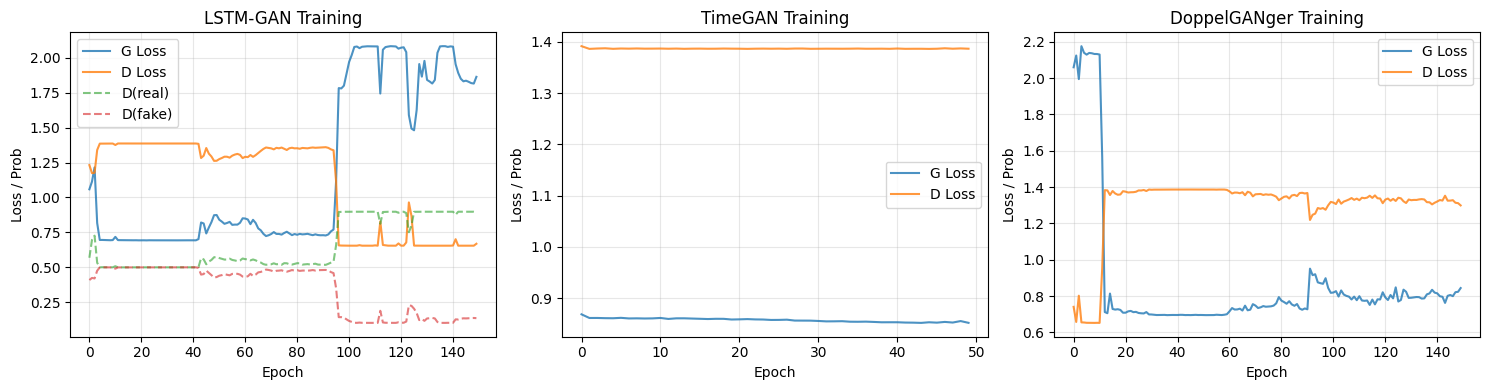

In [21]:
# Training curves with D(real) and D(fake)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (name, hist) in enumerate(histories.items()):
    ax = axes[idx]
    ax.plot(hist['g_loss'], label='G Loss', alpha=0.8)
    ax.plot(hist['d_loss'], label='D Loss', alpha=0.8)
    if 'd_real' in hist:
        ax.plot(hist['d_real'], label='D(real)', linestyle='--', alpha=0.6)
        ax.plot(hist['d_fake'], label='D(fake)', linestyle='--', alpha=0.6)
    ax.set_title(f'{name} Training')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss / Prob')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_curves_fixed.png'), dpi=150)
plt.show()

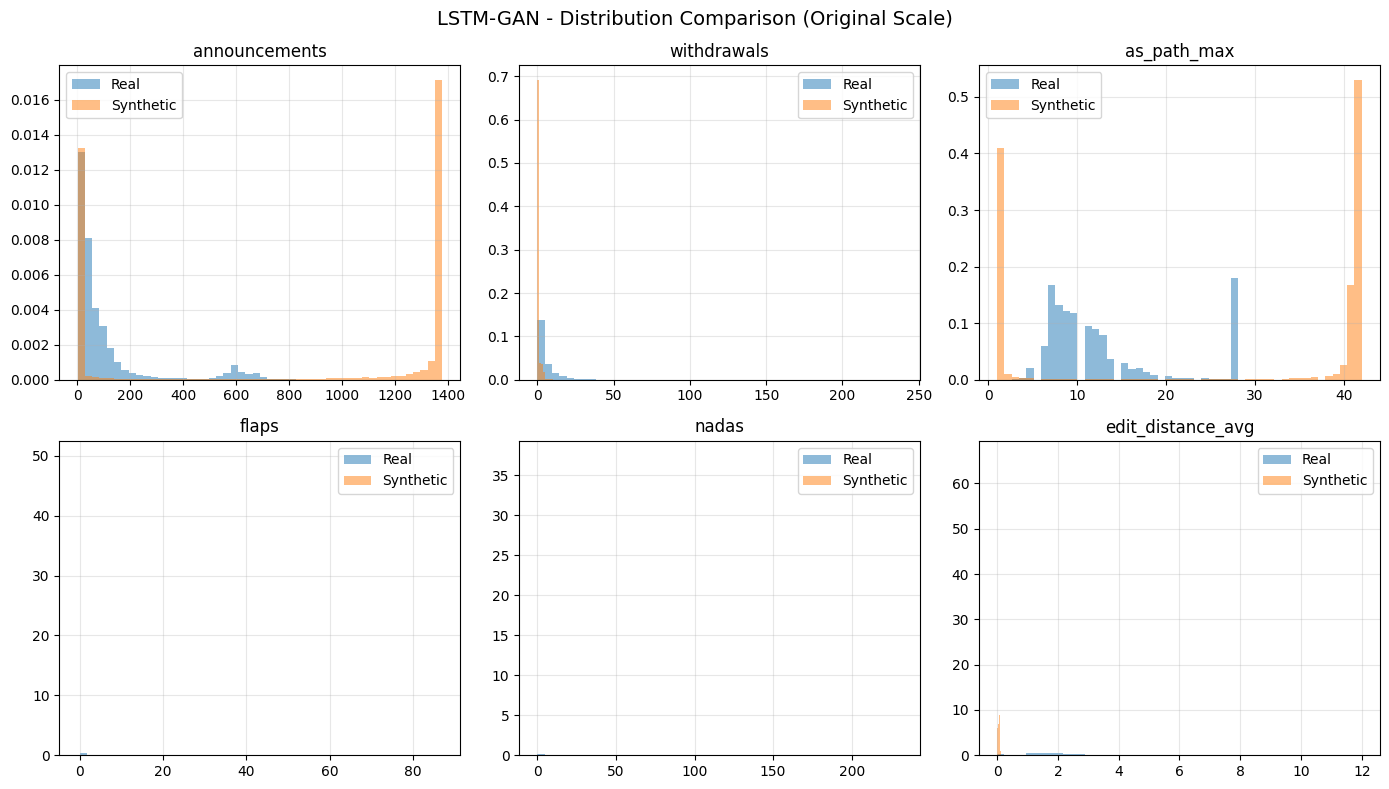

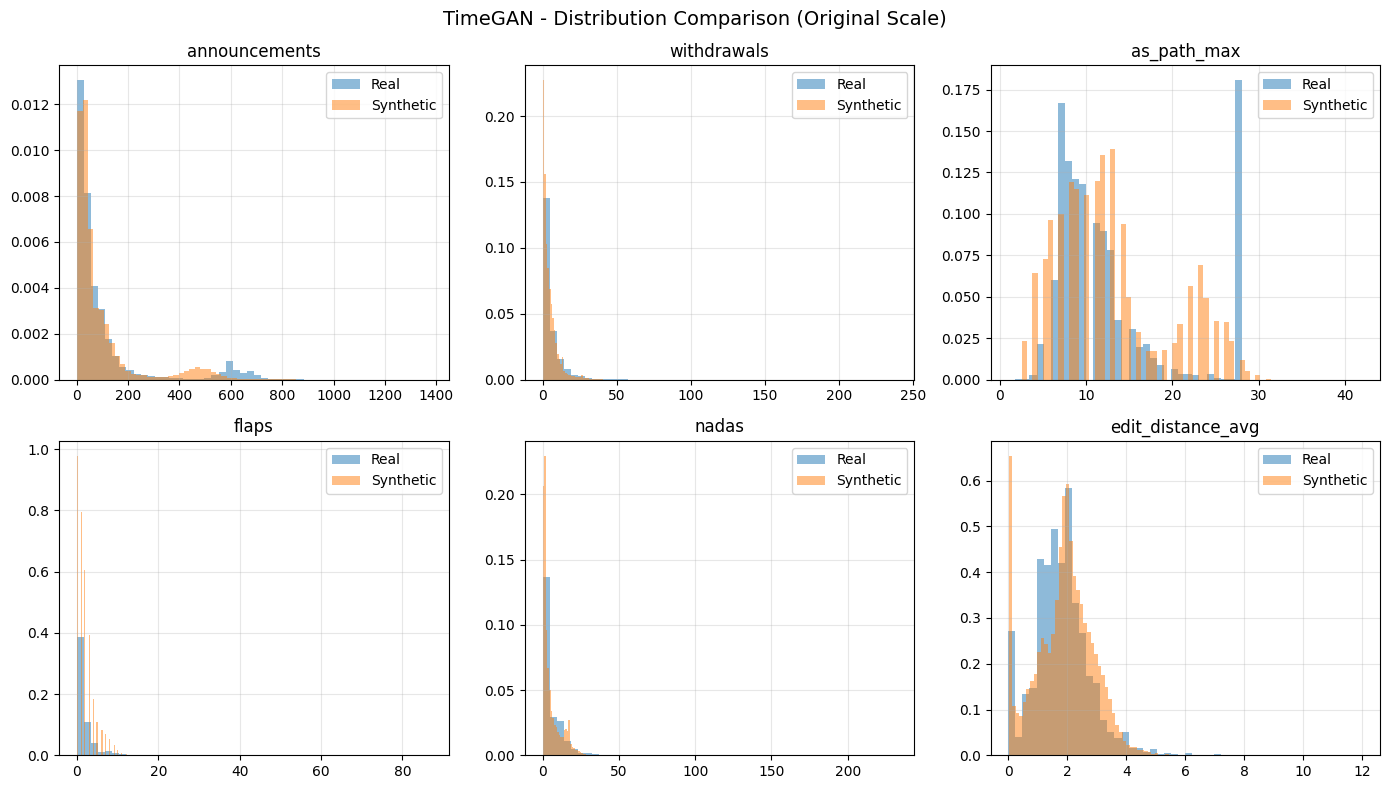

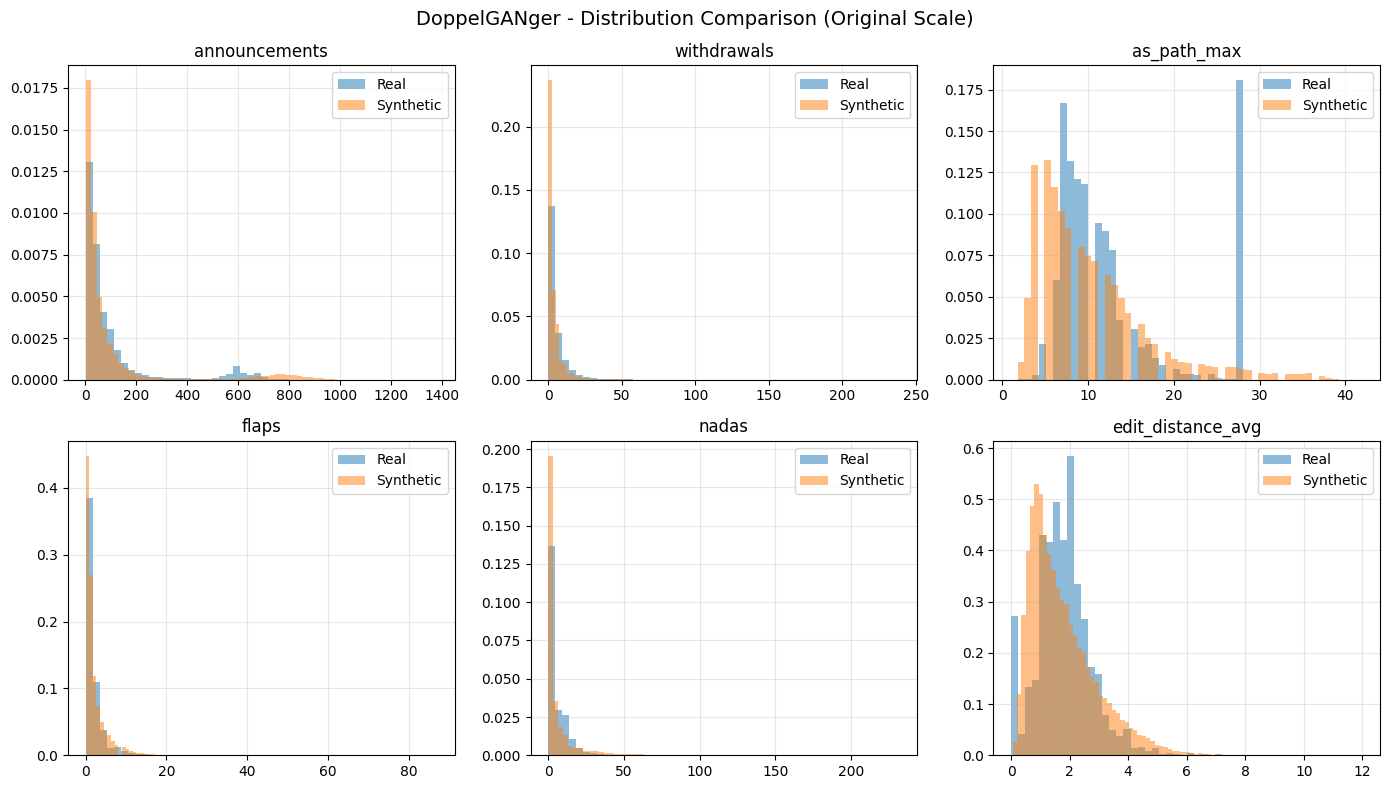

In [22]:
# Distribution comparison (original scale!)
key_features = ['announcements', 'withdrawals', 'as_path_max', 'flaps', 'nadas', 'edit_distance_avg']
key_idx = [available_features.index(f) for f in key_features if f in available_features]

real_flat = X_test_original.reshape(-1, NUM_FEATURES)

for name, syn in synthetic_processed.items():
    syn_flat = syn.reshape(-1, NUM_FEATURES)
    
    fig, axes = plt.subplots(2, 3, figsize=(14, 8))
    axes = axes.flatten()
    
    for i, idx in enumerate(key_idx[:6]):
        axes[i].hist(real_flat[:, idx], bins=50, alpha=0.5, label='Real', density=True)
        axes[i].hist(syn_flat[:, idx], bins=50, alpha=0.5, label='Synthetic', density=True)
        axes[i].set_title(f"{available_features[idx]}")
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.suptitle(f'{name} - Distribution Comparison (Original Scale)', fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f'{name.lower().replace("-", "_")}_dist.png'), dpi=150)
    plt.show()

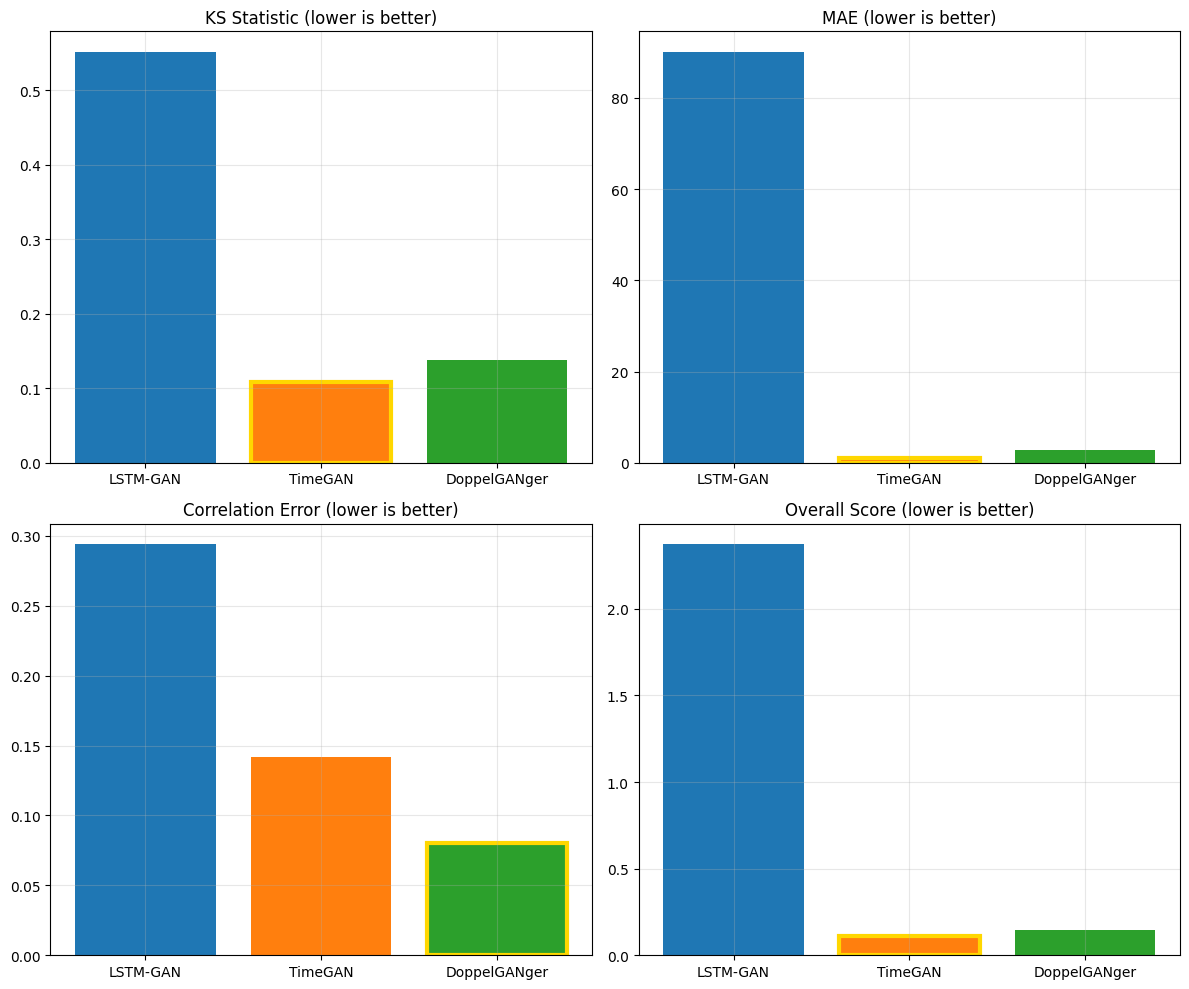

In [23]:
# Model comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

metric_names = ['ks_mean', 'mae_mean', 'corr_error', 'overall_score']
titles = ['KS Statistic', 'MAE', 'Correlation Error', 'Overall Score']
model_names = list(all_metrics.keys())
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, (metric, title) in enumerate(zip(metric_names, titles)):
    values = [all_metrics[m][metric] for m in model_names]
    bars = axes[i].bar(model_names, values, color=colors)
    axes[i].set_title(f'{title} (lower is better)')
    axes[i].grid(True, alpha=0.3)
    
    # Highlight best
    best_idx = np.argmin(values)
    bars[best_idx].set_edgecolor('gold')
    bars[best_idx].set_linewidth(3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'model_comparison_fixed.png'), dpi=150)
plt.show()

## Part 10: Save Results

In [24]:
# Save post-processed synthetic data
print("Saving post-processed synthetic data...")

for name, data in synthetic_processed.items():
    records = []
    for i in range(data.shape[0]):
        for t in range(data.shape[1]):
            rec = {'sequence_id': i, 'timestep': t, 'label': 'normal'}
            for j, feat in enumerate(available_features):
                val = data[i, t, j]
                # Ensure integer features are int
                if feat in INTEGER_FEATURES:
                    rec[feat] = int(val)
                else:
                    rec[feat] = float(val)
            records.append(rec)
    
    df_out = pd.DataFrame(records)
    path = os.path.join(OUTPUT_DIR, f'synthetic_{name.lower().replace("-", "_")}.csv')
    df_out.to_csv(path, index=False)
    print(f"Saved: {path}")

# Save best model's data as main output
best_path = os.path.join(OUTPUT_DIR, 'synthetic_normal_traffic.csv')
import shutil
shutil.copy(
    os.path.join(OUTPUT_DIR, f'synthetic_{best_model.lower().replace("-", "_")}.csv'),
    best_path
)
print(f"Best model output: {best_path}")

Saving post-processed synthetic data...
Saved: /home/smotaali/GAN_Traffic_Producer/results/gan_outputs/synthetic_lstm_gan.csv
Saved: /home/smotaali/GAN_Traffic_Producer/results/gan_outputs/synthetic_timegan.csv
Saved: /home/smotaali/GAN_Traffic_Producer/results/gan_outputs/synthetic_doppelganger.csv
Best model output: /home/smotaali/GAN_Traffic_Producer/results/gan_outputs/synthetic_normal_traffic.csv


In [25]:
# Verify saved data
print("\nVerifying saved data...")
df_check = pd.read_csv(best_path)

print(f"\nSample of saved data:")
print(df_check.head())

print(f"\nData types:")
print(df_check.dtypes[:10])

print(f"\nValue ranges:")
for col in ['announcements', 'withdrawals', 'flaps', 'edit_distance_avg']:
    if col in df_check.columns:
        print(f"  {col}: min={df_check[col].min()}, max={df_check[col].max()}, has_negative={df_check[col].min() < 0}")


Verifying saved data...

Sample of saved data:
   sequence_id  timestep   label  announcements  withdrawals  nlri_ann  dups  \
0            0         0  normal             91           12        91     1   
1            0         1  normal             12            1        12     1   
2            0         2  normal            144            3       144     4   
3            0         3  normal             80            0        80    19   
4            0         4  normal             97           30        97     0   

   origin_0  origin_2  origin_changes  ...  edit_distance_dict_3  \
0        76        15               3  ...                     1   
1         6         6               2  ...                     1   
2       132        12               4  ...                     1   
3        33        60              19  ...                     1   
4        58        38               5  ...                     5   

   edit_distance_dict_4  edit_distance_dict_5  edit_distance_d

In [26]:
# Save scaler and config
with open(os.path.join(OUTPUT_DIR, 'scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)

config = {
    'seq_len': SEQ_LEN,
    'batch_size': BATCH_SIZE,
    'epochs': EPOCHS,
    'lr_g': LR_G,
    'lr_d': LR_D,
    'label_smoothing': LABEL_SMOOTHING,
    'hidden_dim': HIDDEN_DIM,
    'latent_dim': LATENT_DIM,
    'features': available_features,
    'integer_features': INTEGER_FEATURES,
    'continuous_features': CONTINUOUS_FEATURES,
    'best_model': best_model,
    'metrics': {k: {kk: vv for kk, vv in v.items() if kk != 'per_feature'} 
                for k, v in all_metrics.items()},
    'timestamp': datetime.now().isoformat()
}

with open(os.path.join(OUTPUT_DIR, 'config.json'), 'w') as f:
    json.dump(config, f, indent=2, default=str)

print("Saved config.json and scaler.pkl")

Saved config.json and scaler.pkl


In [27]:
# Summary
print("\n" + "="*70)
print("COMPLETE - SUMMARY")
print("="*70)
print(f"""
Fixes Applied:
  ✓ Separate learning rates (G: {LR_G}, D: {LR_D})
  ✓ Label smoothing ({LABEL_SMOOTHING})
  ✓ Sigmoid output (data in [0,1])
  ✓ Post-processing: denormalize → clip → round
  ✓ Fixed MAE calculation (NaN handling)

Results:
  Best Model: {best_model}
  KS Statistic: {all_metrics[best_model]['ks_mean']:.4f}
  MAE: {all_metrics[best_model]['mae_mean']:.4f}

Output: {OUTPUT_DIR}
""")

for f in sorted(os.listdir(OUTPUT_DIR)):
    size = os.path.getsize(os.path.join(OUTPUT_DIR, f)) / 1024
    print(f"  {f}: {size:.1f} KB")


COMPLETE - SUMMARY

Fixes Applied:
  ✓ Separate learning rates (G: 0.0002, D: 0.0001)
  ✓ Label smoothing (0.1)
  ✓ Sigmoid output (data in [0,1])
  ✓ Post-processing: denormalize → clip → round
  ✓ Fixed MAE calculation (NaN handling)

Results:
  Best Model: TimeGAN
  KS Statistic: 0.1090
  MAE: 1.0952

Output: /home/smotaali/GAN_Traffic_Producer/results/gan_outputs/

  config.json: 9.0 KB
  doppelganger_dist.png: 118.9 KB
  lstm_gan_dist.png: 107.6 KB
  model_comparison_fixed.png: 74.9 KB
  scaler.pkl: 1.5 KB
  synthetic_doppelganger.csv: 6342.1 KB
  synthetic_lstm_gan.csv: 6769.1 KB
  synthetic_normal_traffic.csv: 6417.9 KB
  synthetic_timegan.csv: 6417.9 KB
  timegan_dist.png: 113.0 KB
  training_curves_fixed.png: 127.8 KB
